
# Capstone Project Part 1 - Exploratory data analysis (EDA)
## This code was run on Google colab pro

# 1. built connection & Get GPU info

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free:" + humanize.naturalsize(psutil.virtual_memory().available)," |     Proc size:" + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

# 2. read & clean Data

In [2]:
import os
import xml.etree.ElementTree as ET
import glob
import io


In [3]:
def iwslt_clean(directory):
    # Thanks to torchtext for this snippet:
    # https://github.com/pytorch/text/blob/ea64e1d28c794ed6ffc0a5c66651c33e2f57f01f/torchtext/datasets/translation.py#L152
    for xml_filename in glob.iglob(os.path.join(directory, '*.xml')):
        txt_filename = os.path.splitext(xml_filename)[0]
        if os.path.isfile(txt_filename):
            continue

        with io.open(txt_filename, mode='w', encoding='utf-8') as f:
            root = ET.parse(xml_filename).getroot()[0]
            #root = ElementTree.parse(xml_filename).getroot()[0]
            for doc in root.findall('doc'):
                for element in doc.findall('seg'):
                    f.write(element.text.strip() + '\n')

    xml_tags = [
        '<url', '<keywords', '<talkid', '<description', '<reviewer', '<translator', '<title',
        '<speaker'
    ]
    for original_filename in glob.iglob(os.path.join(directory, 'train.tags*')):
        txt_filename = original_filename.replace('.tags', '')
        if os.path.isfile(txt_filename):
            continue

        with io.open(txt_filename, mode='w', encoding='utf-8') as txt_file, \
                io.open(original_filename, mode='r', encoding='utf-8') as original_file:
            for line in original_file:
                if not any(tag in line for tag in xml_tags):
                    txt_file.write(line.strip() + '\n')

In [ ]:
#iwslt_clean('/content/project_data')


# 3. import libs

In [4]:
import pandas as pd
import numpy as np
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle

import pdb
from torch.utils.data import DataLoader

from torch import optim
import time

# 4.Read clean data and Process data (tokenize, WordtoIndex)

In [5]:
UNK_IDX = 2
PAD_IDX = 3
SOS_token = 0
EOS_token = 1

In [6]:
def read_dataset(file):
    f = open(file)
    list_l = []
    for line in f:
        list_l.append(line.strip())
    df = pd.DataFrame()
    df['data'] = list_l
    return df


In [7]:
class Lang:
    def __init__(self, name, minimum_count = 3):
        self.name = name
        self.word2index = {}
        self.word2count = {}
#         self.index2word = {0: "SOS", 1: "EOS", 2:"UKN",3:"PAD"}
        self.index2word = ["SOS","EOS","UKN","PAD"]
        self.n_words = 4  # Count SOS and EOS
        self.minimum_count = minimum_count
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word.lower())
#             if word not in string.punctuation:
#                 self.addWord(word.lower())
    def addSentence_zh(self, sentence):
        for word in list(sentence):
            self.addWord(word.lower())

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1
        if self.word2count[word] >= self.minimum_count:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
    #             self.index2word[self.n_words] = word
                self.index2word.append(word)
                self.n_words += 1

In [8]:
def split(df, char=False):
    df['en_tokenized'] = df["en_data"].apply(lambda x:x.split( ))
    if char:
        df['zh_tokenized'] = df['zh_data'].apply(lambda x:list(x))
    else:
        df['zh_tokenized'] = df['zh_data'].apply(lambda x:x.split())
    return df

In [9]:
def token2index_dataset(df,en_lang,zh_lang):
    for lan in ['en','zh']:
        indices_data = []
        if lan=='en':
            lang_obj = en_lang
        else:
            lang_obj = zh_lang
        for tokens in df[lan+'_tokenized']:
            index_list = [lang_obj.word2index[token.lower()] if token.lower() in lang_obj.word2index else UNK_IDX for token in tokens]
            index_list.append(EOS_token)
#             index_list.insert(0,SOS_token)
            indices_data.append(index_list)
        df[lan+'_idized'] = indices_data
    return df

In [10]:
def train_val_load(MAX_LEN, old_lang_obj, path, char=False):
    if char:
        en_train = read_dataset(path+"train.en")
        en_val = read_dataset(path+"dev.en")
        en_test = read_dataset(path+"test.en")

        zh_train = read_dataset(path+"train.zh")
        zh_val = read_dataset(path+"dev.zh")
        zh_test = read_dataset(path+"test.zh")

    else:
        en_train = read_dataset(path+"train.tok.en")
        en_val = read_dataset(path+"dev.tok.en")
        en_test = read_dataset(path+"test.tok.en")
        
        zh_train = read_dataset(path+"train.tok.zh")
        zh_val = read_dataset(path+"dev.tok.zh")
        zh_test = read_dataset(path+"test.tok.zh")

    train = pd.DataFrame()
    train['en_data'] = en_train['data']
    train['zh_data'] = zh_train['data']
    
    val = pd.DataFrame()
    val['en_data'] = en_val['data']
    val['zh_data'] = zh_val['data']

    test = pd.DataFrame()
    test['en_data'] = en_test['data']
    test['zh_data'] = zh_test['data']
    
    if old_lang_obj:
        with open(old_lang_obj,'rb') as f:
            en_lang = pickle.load(f)
            zh_lang = pickle.load(f)
    else:
        en_lang = Lang("en")
        for ex in train['en_data']:
            en_lang.addSentence(ex)

        if char:
            zh_lang = Lang("zh")
            for ex in train['zh_data']:
                zh_lang.addSentence_zh(ex)
        else:
            zh_lang = Lang("zh")
            for ex in train['zh_data']:
                zh_lang.addSentence(ex)
        
    train = split(train, char=char)
    val = split(val, char=char)
    test = split(test, char=char)
    
    train = token2index_dataset(train,en_lang,zh_lang)
    val = token2index_dataset(val,en_lang,zh_lang)
    test = token2index_dataset(test,en_lang,zh_lang)

    train['en_len'] = train['en_idized'].apply(lambda x: len(x))
    train['zh_len'] = train['zh_idized'].apply(lambda x:len(x))
    
    val['en_len'] = val['en_idized'].apply(lambda x: len(x))
    val['zh_len'] = val['zh_idized'].apply(lambda x: len(x))

    test['en_len'] = test['en_idized'].apply(lambda x: len(x))
    test['zh_len'] = test['zh_idized'].apply(lambda x: len(x))
    
    train = train[np.logical_and(train['en_len']>=2,train['zh_len']>=2)]
#     train = train[train['vi_len']<=MAX_LEN]
    
    val = val[np.logical_and(val['en_len']>=2,val['zh_len']>=2)]
#     val = val[val['vi_len']<=MAX_LEN]
    
    test = test[np.logical_and(test['en_len']>=2,test['zh_len']>=2)]
#     train = train[train['vi_len']<=MAX_LEN]

    return train,val,test,en_lang,zh_lang

In [11]:

import pdb
import logging
import itertools
import argparse
import math
import copy
import time
import os


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
import torchtext
from torch.utils.data import BatchSampler
from torch.utils.data import SequentialSampler
from torch.utils.data import Sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

#from bleu_score import BLEU_SCORE
#from load_dataset_zh_wcharoption import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import matplotlib as mpl

In [12]:
#device = torch.device('cuda')
#device = torch.device('cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class Chinese(Dataset):
    def __init__(self, df, val = False):
        self.df = df
        self.val = val
        
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        english = self.df.iloc[idx,:]['en_idized']
        chin = self.df.iloc[idx,:]['zh_idized']
        en_len = self.df.iloc[idx,:]['en_len']
        zh_len = self.df.iloc[idx,:]['zh_len']
        if self.val:
            en_data = self.df.iloc[idx,:]['en_data'].lower()
            return [chin,english,zh_len,en_len,en_data]
        else:
            return [chin,english,zh_len,en_len]
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
def vocab_collate_func(batch):
    MAX_LEN_EN = 30
    MAX_LEN_zh = 30
    en_data = []
    zh_data = []
    en_len = []
    zh_len = []
    for datum in batch:
        en_len.append(datum[3])
        zh_len.append(datum[2])
    max_batch_length_en = max(en_len)
    max_batch_length_zh = max(zh_len)
    if max_batch_length_en < MAX_LEN_EN:
        MAX_LEN_EN = max_batch_length_en
    if max_batch_length_zh < MAX_LEN_zh:
        MAX_LEN_zh = max_batch_length_zh
    # padding
    for datum in batch:
        if datum[2]>MAX_LEN_zh:
            padded_vec_s1 = np.array(datum[0])[:MAX_LEN_zh]
        else:
            padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,MAX_LEN_zh - datum[2])),
                                mode="constant", constant_values=PAD_IDX)
        if datum[3]>MAX_LEN_EN:
            padded_vec_s2 = np.array(datum[1])[:MAX_LEN_EN]
        else:
            padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,MAX_LEN_EN - datum[3])),
                                mode="constant", constant_values=PAD_IDX)
        en_data.append(padded_vec_s2)
        zh_data.append(padded_vec_s1)
    zh_data = np.array(zh_data)
    en_data = np.array(en_data)
    zh_len = np.array(zh_len)
    en_len = np.array(en_len)

    zh_len[zh_len>MAX_LEN_zh] = MAX_LEN_zh
    en_len[en_len>MAX_LEN_EN] = MAX_LEN_EN
        
    return [torch.from_numpy(zh_data), torch.from_numpy(en_data),
            torch.from_numpy(zh_len), torch.from_numpy(en_len)]

def convert_idx_2_sent(tensor, lang_obj):
    word_list = []
    for i in tensor:
        if i.item() not in set([PAD_IDX,EOS_token,SOS_token]):
            word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

def convert_id_list_2_sent(list_idx, lang_obj):
    word_list = []
    if type(list_idx) == list:
        for i in list_idx:
            if i not in set([EOS_token]):
                word_list.append(lang_obj.index2word[i])
    else:
        for i in list_idx:
            if i.item() not in set([EOS_token,SOS_token,PAD_IDX]):
                word_list.append(lang_obj.index2word[i.item()])
    return (' ').join(word_list)

In [14]:
def vocab_collate_func_val(batch):
    return [torch.from_numpy(np.array(batch[0][0])).unsqueeze(0), torch.from_numpy(np.array(batch[0][1])).unsqueeze(0),
            torch.from_numpy(np.array(batch[0][2])).unsqueeze(0), torch.from_numpy(np.array(batch[0][3])).unsqueeze(0),batch[0][4]]

In [15]:
# MAX_LEN = 57
# use character level chinese
train,val,test,en_lang,zh_lang = train_val_load(57, "", '/content/drive/MyDrive/processed_data/', char=True)

# 5.EDA

In [16]:
train.head()

,en_data,zh_data,en_tokenized,zh_tokenized,en_idized,zh_idized,en_len,zh_len
0,Today I'm going to speak to you about the las...,今天我要跟大家讲述 过去30年的建筑史。,"[Today, I'm, going, to, speak, to, you, about,...","[今, 天, 我, 要, 跟, 大, 家, 讲, 述, , 过, 去, 3, 0, 年, ...","[790, 293, 118, 4, 775, 4, 26, 20, 11, 58, 59,...","[295, 138, 8, 87, 391, 94, 17, 269, 270, 6, 88...",16,21
1,That's a lot to pack into 18 minutes.,太多东西要在这18分钟内讲述了。,"[That's, a, lot, to, pack, into, 18, minutes.]","[太, 多, 东, 西, 要, 在, 这, 1, 8, 分, 钟, 内, 讲, 述, 了, 。]","[19, 5, 270, 4, 2, 69, 794, 2, 1]","[147, 52, 69, 9, 87, 11, 4, 174, 148, 100, 128...",9,17
2,"It's a complex topic, so we're just going to ...",这是一个复杂的题目， 那就让我们从这个复杂的地方开始： 新泽西。,"[It's, a, complex, topic,, so, we're, just, go...","[这, 是, 一, 个, 复, 杂, 的, 题, 目, ，, , 那, 就, 让, 我, ...","[21, 5, 390, 2, 42, 52, 79, 118, 4, 2, 308, 7,...","[4, 12, 95, 15, 364, 661, 5, 345, 360, 10, 6, ...",19,33
3,"Because 30 years ago, I'm from Jersey, and I ...",三十年前，我住新泽西 那时我六岁，我住在父母家 小镇名叫Livingston， 这是我儿时的卧室。,"[Because, 30, years, ago,, I'm, from, Jersey,,...","[三, 十, 年, 前, ，, 我, 住, 新, 泽, 西, , 那, 时, 我, 六, ...","[23, 59, 27, 322, 293, 14, 2, 8, 12, 10, 2, 8,...","[313, 431, 45, 56, 10, 8, 63, 72, 883, 9, 6, 1...",31,50
4,Around the corner from my bedroom was the bat...,在我卧室的角落 是我和姐姐共用的洗手间。,"[Around, the, corner, from, my, bedroom, was, ...","[在, 我, 卧, 室, 的, 角, 落, , 是, 我, 和, 姐, 姐, 共, 用, ...","[92, 11, 891, 14, 9, 15, 10, 11, 2, 13, 12, 32...","[11, 8, 13, 14, 5, 690, 328, 6, 12, 8, 42, 976...",18,21


In [ ]:
train.shape

(1205, 8)

In [17]:
#First Chinese sentence in the training dataset
train.zh_data[0]

'今天我要跟大家讲述 过去30年的建筑史。'

In [18]:
#First English sentence in the training dataset
train.en_data[0]

"Today I'm going to speak to you  about the last 30 years of architectural history."

# 6. Chinese & English wordclouds on the training dataset

In [19]:
#import libs
import warnings
warnings.filterwarnings("ignore")
import jieba    #分词包
import numpy    #numpy计算包
import codecs   #codecs提供的open方法来指定打开的文件的语言编码，它会在读取的时候自动转换为内部unicode 
  
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
from wordcloud import WordCloud,STOPWORDS #词云包

### 6.1 Chinese dataset preparation for wordclouds 导入数据，分词：

In [20]:
df=train[['zh_data']]
df = df.dropna()
content=df.zh_data.values.tolist()
#jieba.load_userdict(u"data/user_dic.txt")
segment=[]
for line in content:
    try:
        segs=jieba.lcut(line)
        print(segs)
        for seg in segs:
            if len(seg)>1 and seg!='\r\n':
                segment.append(seg)
    except:
        print(line)
        continue
print(segment)      

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.030 seconds.
Prefix dict has been built successfully.


['今天', '我要', '跟', '大家', '讲述', ' ', '过去', '30', '年', '的', '建筑史', '。']
['太', '多', '东西', '要', '在', '这', '18', '分钟', '内', '讲述', '了', '。']
['这是', '一个', '复杂', '的', '题目', '，', ' ', '那', '就让', '我们', '从', '这个', '复杂', '的', '地方', '开始', '：', ' ', '新泽西', '。']
['三十年', '前', '，', '我住', '新泽西', ' ', '那时', '我', '六岁', '，', '我', '住', '在', '父母', '家', ' ', '小镇', '名叫', 'Livingston', '，', ' ', '这', '是', '我', '儿时', '的', '卧室', '。']
['在', '我', '卧室', '的', '角落', ' ', '是', '我', '和', '姐姐', '共用', '的', '洗手间', '。']
['在', '我', '的', '卧室', '和', '浴室', '之间', ' ', '是', '一个', '可以', '看到', '客厅', '的', '阳台', '。']
['那', '是', '家人', '聚会', '，', '看电视', '的', '客厅', '，', ' ', '每次', '我', '从', '卧室', '走', '去', '浴室', '的', '时候', '，', ' ', '每个', '人', '都', '能', '看到', '我', '，', ' ', '每次', '我', '洗完', '澡', ' ', '裹', '着', '浴巾', '走', '回', '卧室', '，', ' ', '每个', '人', '都', '能', '看到', '我', '，']
['我', '看起来', '是', '这样', '。']
['我', '很', '尴尬', '，', ' ', '没有', '安全感', '，', '我', '讨厌', '我', '的', '房间', '。']
['我', '讨厌', '那段', '路', '，', '我', '讨厌', '那个', '阳台', '，', 

In [21]:
#put tokenized Chinese words back into DataFrame
words_df=pd.DataFrame({'segment':segment})
#words_df.head()

#read Chinese stopwords
stopwords=pd.read_csv("/content/drive/MyDrive/第05-06课/NLP_project/NLP_project/data/stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')#quoting=3全不引用
#stopwords.head()

#remove Chinese stopwords
words_df=words_df[~words_df.segment.isin(stopwords.stopword)]

#words_df

In [ ]:
# words_stat=words_df.groupby(by=['segment'])['segment'].agg(numpy.size) #words_stat--> Series
# #words_stat
# words_stat=words_stat.to_frame() #dataframe
# #words_stat
# words_stat.columns=['计数'] #rename the column

In [ ]:
#words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False) # 排序sorting out the order


In [22]:
#print(words_stat.head(5))#Top 5 words

In [23]:
words_stat=words_df.groupby(by=['segment'])['segment'].agg(numpy.size) #words_stat--> Series
words_stat=words_stat.to_frame()
words_stat.columns=['计数']
#print(words_stat.head(5))
words_stat=words_stat.reset_index().sort_values(by=["计数"],ascending=False) # 排序
#print(words_stat.head(5))
words_stat

,segment,计数
1411,意识,86
1256,建筑,79
970,大脑,31
810,告诉,31
187,世界,29
...,...,...
1251,废除,1
1252,度假,1
1253,座位,1
1254,建成,1


### 6.2 Chinese wordcloud

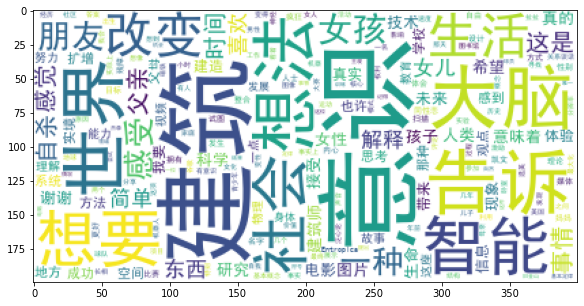

In [24]:
wordcloud=WordCloud(font_path="/content/drive/MyDrive/第05-06课/NLP_project/NLP_project/data/simhei.ttf",background_color="white",max_font_size=80)
#wordcloud=WordCloud(font_path="data/simhei.ttf",background_color="black",max_font_size=80)
word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

### 6.3 using your own image for Chinese wordcloud

In [25]:
import imageio

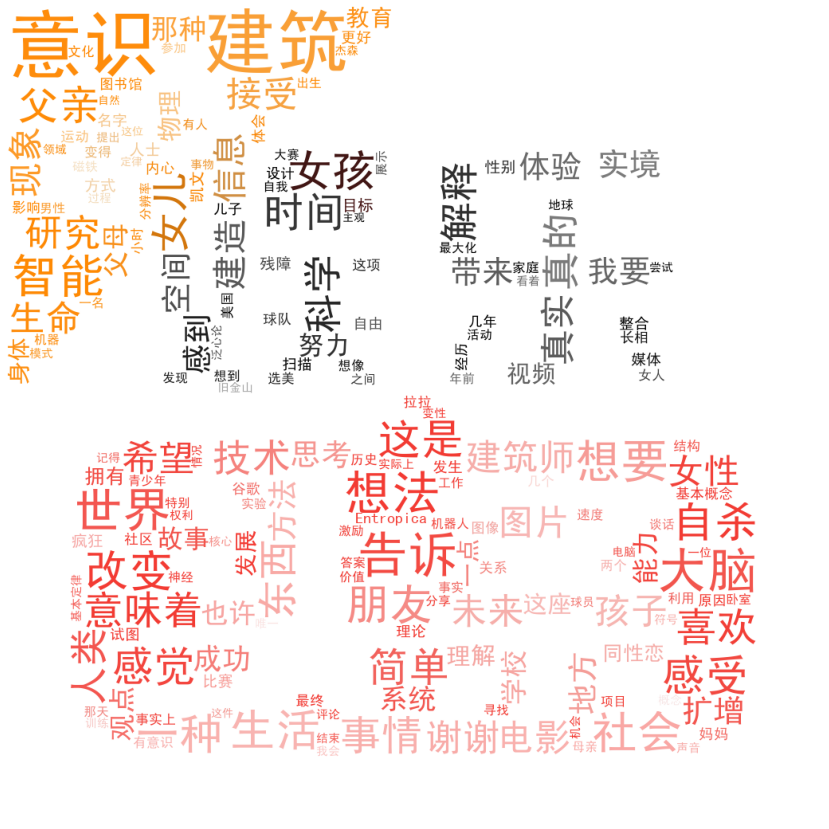

In [26]:
#from scipy.misc import imread
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
from wordcloud import WordCloud,ImageColorGenerator
bimg=imageio.imread('/content/drive/MyDrive/第05-06课/NLP_project/NLP_project/image/entertainment.jpeg')
wordcloud=WordCloud(background_color="white",mask=bimg,font_path='/content/drive/MyDrive/第05-06课/NLP_project/NLP_project/data/simhei.ttf',max_font_size=200)
word_frequence = {x[0]:x[1] for x in words_stat.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence)
bimgColors=ImageColorGenerator(bimg)
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=bimgColors))


### 6.4 English WordCloud

In [27]:
!pip install nltk

In [28]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
 #add new words to the list
 #add new words to the list
new_stopwords = ["I", "And", "So"]#add your own stop words
stopwords_En = nltk.corpus.stopwords.words('english')
stopwords_En.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
#stopwords_En = set (STOPWORDS)
stopwords_En = pd.DataFrame (stopwords_En, columns = ['stopwords_En'])
#stopwords_En.head()

In [ ]:
#frequency count
c = Counter()
df_c = train[['en_data']]
df_c.en_data.str.split().apply(c.update)
c

In [31]:
# words stat dataframe
words_stat_En = pd.DataFrame.from_records(list(dict(c).items()), columns=['Word','count'])
words_stat_En = words_stat_En.sort_values(by='count',ascending=False)
words_stat_En.head(1)

,Word,count
7,the,789


In [32]:
#remove stopwords
words_stat_En=words_stat_En[~words_stat_En.Word.isin(stopwords_En.stopwords_En)]
words_stat_En

,Word,count
89,like,76
71,would,56
160,think,53
222,people,51
309,one,48
...,...,...
2267,describes,1
2270,bunch,1
2271,"equations,",1
2272,underlies,1


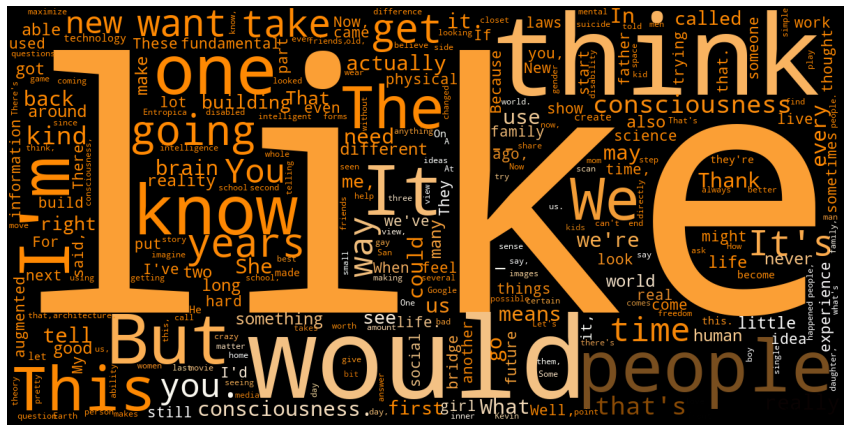

In [33]:
#English wordcloud
wordcloud =WordCloud(
        background_color="Black",
        #mask=bimg,font_path='/content/drive/MyDrive/第05-06课/NLP_project/NLP_project/data/simhei.ttf',
        max_font_size=200,
        max_words=1000,
        scale=3,
        contour_width=1
        )

word_frequence_En = {x[0]:x[1] for x in words_stat_En.head(1000).values}
wordcloud=wordcloud.fit_words(word_frequence_En)   
bimgColors=ImageColorGenerator(bimg)
plt.axis("off")
plt.imshow(wordcloud.recolor(color_func=bimgColors))
